<a href="https://colab.research.google.com/github/jjablonski-it/pjatk-mhe/blob/main/MHE_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import random
import math
from time import time
import matplotlib.pyplot as plt

In [18]:
# constants
LENGTH = 100
VALUE_RANGE = 10000

In [19]:
data = [random.randint(-VALUE_RANGE,VALUE_RANGE) for _ in range(LENGTH)]
# data[0] = 0
print(0 in data)

False


In [20]:
# functions
def random_index():
    return ''.join(['%d' % random.randint(0, 1) for _ in range(LENGTH)])


def index_to_set(index):
    result = []
    for i, x in enumerate(list(index)):
        if(x == '1'):
            result.append(i)
    return list(map(lambda x: data[x], result))


def subset_sum(index):
    return abs(sum(index_to_set(index)))


def negate_bit(index, n):
    index_list = list(index)
    bit = index_list[n]
    index_list[n] = '1' if bit == '0' else '0'
    return ''.join(index_list)


def generate_neighbours(index):
    return filter(lambda x: x != '0'*LENGTH, [negate_bit(index, x) for x in range(LENGTH)])


def get_best_index(indices):
    sum_dict = {index: subset_sum(index) for index in indices}
    return min(sum_dict, key=sum_dict.get)


def plot_indices_to_sum(indices):
    plt.plot(list(map(lambda x: subset_sum(x), indices)))


def bruteforce_lowest_sum(val=0):
    all_indices = list(
        map(lambda x: ("{:0"+str(LENGTH)+"b}").format(x), range(1, 2**LENGTH)))
    print('generated all incides, testing...')
    best = subset_sum(all_indices[0])
    for x in all_indices:
        result = subset_sum(x)
        if(result <= val):
            return result
        if(result < best):
            best = result
    return best


In [63]:
def hill_climbing_deterministic(index=random_index()):
    while True:
        current_sum = subset_sum(index)
        neighbours = generate_neighbours(index)
        neighbour_sum_dict = {index: subset_sum(index) for index in neighbours}
        # determine best neighbour
        best_index = min(neighbour_sum_dict, key=neighbour_sum_dict.get)
        if(neighbour_sum_dict[best_index] < current_sum):
            index = best_index
        else:
            return index


def hill_climbing_stochastic(index=random_index(), iterations=100):
  def select_neighbour(neighbours):
    neighbour_sum_dict = {index: subset_sum(index) for index in neighbours}
    sorted_neighbours = sorted(neighbour_sum_dict.items(), key=lambda item: item[1])
    if sorted_neighbours[0][1]==0:
      return sorted_neighbours[0][0]
    points_arr = [(VALUE_RANGE*LENGTH)//sum for _, sum in sorted_neighbours]
    total_points = sum(points_arr)
    probability_arr = list(map(lambda x: x/total_points, points_arr))

    random_val = random.random()
    best_i = next(i for i, _ in enumerate(probability_arr) if sum(probability_arr[:i+1]) > random_val)
    return sorted_neighbours[best_i][0]

  i = 0
  while i < iterations:
    current_sum = subset_sum(index)
    if(current_sum==0):
      return index
    neighbours = generate_neighbours(index)
    index = select_neighbour(neighbours)
    i += 1
  return index


def tabu_search(index=random_index(), iterations_limit=100):  # with going back
    tl = set()  # tabu list
    l = [index]  # steps list
    best_index = index
    current_index = index
    i = 0
    while i < iterations_limit and subset_sum(best_index) != 0 and l:
        i += 1
        # print(i, 'index', current_index, 'sum', subset_sum(current_index))
        neighbours = generate_neighbours(current_index)
        neighbour_sum_dict = {index: subset_sum(
            index) for index in neighbours}  # {index -> sum} dict
        sorted_neighbours = map(lambda x: x[0], sorted(
            neighbour_sum_dict.items(), key=lambda item: item[1]))  # [index] array
        valid_neighbours = list(
            filter(lambda x: x not in tl, sorted_neighbours))

        tl.add(current_index)
        if valid_neighbours:
            best_local_index = valid_neighbours.pop(0)
            if subset_sum(best_local_index) < subset_sum(best_index):
                l.append(current_index)
                best_index = best_local_index
            current_index = best_local_index
        else:
            current_index = l.pop()
    return best_index


class SA:
    def __init__(self, start_index, temp, max_iterations) :
        self.index = start_index
        self.iteration = 1
        self.temp = temp
        self.max_iterations = max_iterations
        self.best_index = self.index
        self.best_index_per_iteration = []
        self.prob_per_iteration = [1]
        self.temp_per_iteration = []

    def calculate_cost(self, index):
        return subset_sum(index)

    def get_temp(self):
        return self.temp / math.log(self.iteration + 1)

    def should_accept(self, cost_diff):
        res = math.exp(-abs(cost_diff)/self.get_temp())
        self.prob_per_iteration.append(res)
        return random.random() < res 

    def update_values(self):
        if subset_sum(self.index) < subset_sum(self.best_index):
            self.best_index = self.index
        self.best_index_per_iteration.append(self.index)
        self.temp_per_iteration.append(self.get_temp())

    def end_condition(self):
        return subset_sum(self.index) == 0

    def run(self):
        while(self.iteration < self.max_iterations):
            next_index = random.choice(list(generate_neighbours(self.index)))
            diff = self.calculate_cost(self.index) - self.calculate_cost(next_index)
            if diff >= 0:
                self.index = next_index
                self.prob_per_iteration.append(self.prob_per_iteration[-1])
            else:
                if self.should_accept(diff):
                    self.index = next_index
            self.update_values()
            if self.end_condition():
                return self.index
            self.iteration += 1
        return self.index



class GA:
    def __init__(self, pop_size, mutation_rate):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.generation = self.create_generation()
        self.generation_count = 0
        self.best_index = get_best_index(self.generation)
        self.best_indices_per_gen = [self.best_index]
        self.average_sum_per_gen = [self.get_average_sum()]

    def crossover(self, index_a, index_b):
        slice_point_1, slice_point_2 = sorted(
            [random.randint(0, LENGTH-1), random.randint(0, LENGTH-1)])
        child = index_a[:slice_point_1] + \
            index_b[slice_point_1:slice_point_2] + index_a[slice_point_2:]
        return child

    def mutate(self, index):
        rand_index = random_index()
        mutated_index = self.crossover(index, rand_index)
        return mutated_index

    def end_condition(self):
        return subset_sum(self.best_index) == 0

    def next_generation(self):
        mating_pool = self.create_mating_pool()
        parent = self.select_parent(mating_pool)
        next_generation = self.mate(parent)
        self.generation = self.create_generation(next_generation)
        self.generation_count += 1
        self.update_best_index()

    def fitness_function(self, index):
        index_sum = subset_sum(index)
        if(index_sum == 0):
            return ((VALUE_RANGE*LENGTH) * 2)
        score = ((VALUE_RANGE*LENGTH) // index_sum)
        return score

    def next_generations(self, n):
        for _ in range(n):
            self.next_generation()
            if self.end_condition():
                return self.best_index
        return self.best_index

    def create_generation(self, start_array=[]):
        generation = set(start_array)
        while(len(generation) < self.pop_size):
            generation.add(random_index())
        return generation

    def create_mating_pool(self):
        index_score_dict = {index: self.fitness_function(
            index) for index in self.generation}
        total = sum(index_score_dict.values())
        index_prob_dict = {index: math.floor(
            (score/total)*100) for index, score in index_score_dict.items()}
        pool_nested = [[index]*(prob)
                       for index, prob in index_prob_dict.items()]
        return [item for sublist in pool_nested for item in sublist]

    def mutation(self, index):
        rand = random.random()
        if rand < self.mutation_rate:
            return self.mutate(index)
        return index

    def select_parent(self, pool):
        return random.choice(pool)

    def mate(self, parent_index):
        new_generation = map(lambda index: self.mutation(
            self.crossover(index, parent_index)), self.generation)
        return set(new_generation)

    def update_best_index(self):
        current_best = get_best_index(self.generation)
        self.best_indices_per_gen.append(current_best)
        self.average_sum_per_gen.append(self.get_average_sum())
        if(subset_sum(current_best) < subset_sum(self.best_index)):
            self.best_index = current_best

    def get_average_sum(self):
        return sum(map(lambda index: subset_sum(index), self.generation))/len(self.generation)

    def show_status(self):
        print('generation_count', self.generation_count)
        print('average_sum', self.get_average_sum())
        print('best_sum', subset_sum(self.best_index))
        print('curr_best_sum', subset_sum(self.best_indices_per_gen[-1]))


class GA_island:
    def __init__(self, island_count, migration_speed, migration_pause, *args):
        self.generation_count = 0
        self.islands = [GA(*args) for _ in range(island_count)]
        self.island_count = island_count
        self.migration_speed = migration_speed
        self.migration_pause = migration_pause
        self.best_index = self.islands[0].best_index

    def migrate(self):
        for _ in range(self.migration_speed):
            emigrant = self.islands[-1].generation.pop()
            for ga in self.islands:
                ga.generation.add(emigrant)
                if ga != self.islands[-1]:
                    emigrant = ga.generation.pop()

    def next_generations(self, n):
        end = False
        for _ in range(n):
            if end:
                break
            if self.generation_count % self.migration_pause == 0:
                self.migrate()
            for ga in self.islands:
                ga.next_generation()
                if subset_sum(ga.best_index) < subset_sum(self.best_index):
                    self.best_index = ga.best_index
                if ga.end_condition():
                    end = True
                    return ga.best_index
            self.generation_count += 1
        return self.best_index

    def get_best_overall(self):
        best_arr = list(
            map(lambda ga: subset_sum(ga.best_index), self.islands))
        best_overall = min(best_arr)
        return best_overall

    def show_status(self):
        for i, ga in enumerate(self.islands):
            print(i)
            ga.show_status()
            print()

In [112]:
start_index = random_index()
iterations = 10000

sa = SA(start_index, 1000, iterations)
ga = GA(100, 0.01)
ga_islands = GA_island(10, 10, 10, 100, 0.01)

algorithms = {
    'HCD': lambda: hill_climbing_deterministic(start_index),
    'HCS': lambda: hill_climbing_stochastic(start_index, iterations),
    'TABU': lambda: tabu_search(start_index, iterations),
    'SA': lambda: sa.run(),
    'GA': lambda: ga.next_generations(iterations),
    'GAI': lambda: ga_islands.next_generations(iterations),
}

In [113]:
def test_all(n):
  results = {}
  for name, algorithm in algorithms.items():
    print(name)
    result = {'success': 0, 'duration': 0, 'best_sum': 0}
    for _ in range(n):
      s_time = time()
      best_index = algorithm()
      best_sum = subset_sum(best_index)
      duration = time() - s_time
      success = subset_sum(best_index) == 0
      result['success'] += success
      result['duration'] += duration
      result['best_sum'] += best_sum
    results[name] = {'success': result['success'], 'av_duration': result['duration']/n, 'av_best_sum': result['best_sum']/n}
  for key in ['success', 'av_duration', 'av_best_sum']:
    plt.figure(figsize=(10,10))
    plt.figtext(.5, .9, key)
    plt.bar(results.keys(), [result[key] for result in results.values()])

HCD
HCS
TABU
SA
GA
GAI


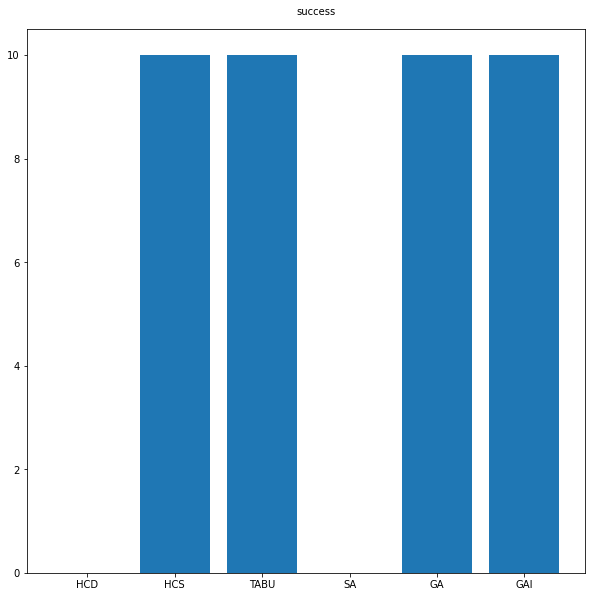

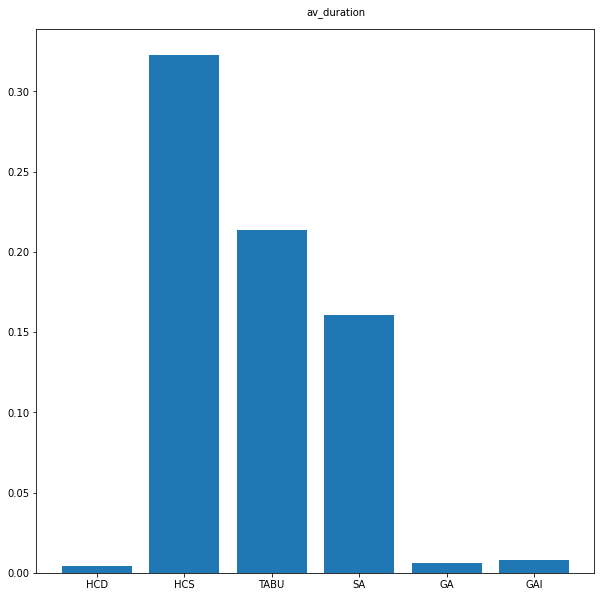

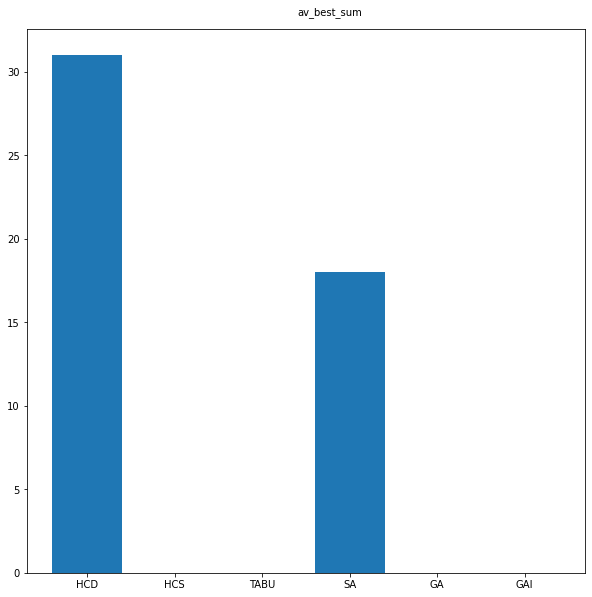

In [114]:
test_all(10)